In [8]:
import pandas as pd
import numpy as np
import biosppy.signals.ecg as ecg
import matplotlib.pyplot as plt
import neurokit2 as nk
import statistics
import math

In [3]:
train_x = pd.read_csv("X_train.csv")
train_y = pd.read_csv("y_train.csv")
test_x = pd.read_csv("X_test.csv")
train_signal = train_x.drop('id',axis = 1)
test_signal = test_x.drop('id',axis = 1)

In [4]:
def get_r_loc(beat):
  beat_len = len(beat)
  half_index = int(beat_len*0.5)
  half = beat[0:half_index]
  r = np.where(beat==max(half))[0][0]
  return r

def get_q_loc(beat,r_loc):
#  q_loc = waves['ECG_Q_Peaks']
#  na_loc = np.argwhere(np.isnan(q_loc)).reshape(1,-1)[0]
#  if (len(na_loc)!=0):
#    for na in na_loc:
#      r = rpeaks[na]
  before_r = beat[(r_loc-35):r_loc]
  q = np.where(beat==min(before_r))[0][0]
  return q

def get_p_loc(beat,q_loc):
#  p_loc = waves['ECG_P_Peaks']
#  na_loc = np.argwhere(np.isnan(p_loc)).reshape(1,-1)[0]
#  if (len(na_loc)!=0):
#    for na in na_loc:
  p = np.where(beat==max(beat[0:q_loc]))[0][0]
  return p

def get_s_loc(beat,r_loc):
  after_r = beat[r_loc+1:r_loc+30]
  s = np.where(beat==min(after_r))[0][0]
  return s

def get_t_loc(beat,s_loc):
  after_s = beat[s_loc+1:]
  t = s_loc+np.where(after_s==max(after_s))[0][0]
  return t

In [5]:
def get_statistics(lis):
  mean = np.mean(lis)
  if(len(lis)>=2):
    sd = np.std(lis)
  else:
    sd = 0
  median = np.median(lis)
  ma = max(lis)
  mi = min(lis)
  return mean,median,sd,ma,mi

In [6]:
def get_interval_and_amplitude(signal,loc1,loc2,averaged_beat,name,beat_num):
  interval = []
  average_interval = 0
  amplitudes1 = []
  amplitudes2 = []


  #sometimes p peaks appears in the second heartbeat
  for i in range(min(len(loc1),len(loc2),beat_num)):
    if((not math.isnan(loc1[i])) and (not math.isnan(loc2[i]))):
      if(loc1[i]>loc2[i]):
        if(i+1<len(loc2)):
          interval.append(loc2[i+1]-loc1[i])
      else:
        interval.append(loc2[i]-loc1[i])
      amplitudes1.append(signal[loc1[i]])
      amplitudes2.append(signal[loc2[i]])
  
  if(len(interval) == 0):
    r_loc = get_r_loc(averaged_beat)
    if(name == 'pr_interval'):
      q_loc = get_p_loc(averaged_beat,r_loc)
      p_loc = get_p_loc(averaged_beat,q_loc)
      average_amplitude1 = averaged_beat[p_loc]
      average_amplitude2 = averaged_beat[r_loc]
      average_interval == r_loc-p_loc
    elif(name == 'st_interval'):
      s_loc = get_s_loc(averaged_beat,r_loc)
      t_loc = get_t_loc(averaged_beat,s_loc)
      average_amplitude1 = averaged_beat[s_loc]
      average_amplitude2 = averaged_beat[t_loc]
      average_interval = t_loc-s_loc
    elif(name == 'qrs_duration'):
      s_loc = get_s_loc(averaged_beat,r_loc)
      q_loc = get_q_loc(averaged_beat,r_loc)
      average_amplitude1 = averaged_beat[q_loc]
      average_amplitude2 = averaged_beat[r_loc]
      average_interval = s_loc - q_loc
  else:
    average_interval = np.mean(interval)
    average_amplitude1 = np.mean(amplitudes1)
    average_amplitude2 = np.mean(amplitudes2)
  return average_interval,average_amplitude1,average_amplitude2


In [ ]:
all_features = []
for i in range(train_signal.shape[0]):
#for i in range(5):
  print(i)
  features = []
  averaged_beat = []
  sd_beat = []
  signal = np.array(train_signal.iloc[i].dropna())
  ts, filtered, rpeaks, templates_ts, templates, heart_rate_ts, heart_rate = ecg.ecg(signal, sampling_rate=300, show=False)
  beat_num = templates.shape[0]
  beat_len = templates.shape[1]

  if(beat_num==0):
    print(i,': no heartbeat is extracted from this signal!')
    continue
  else:
    averaged_beat = np.mean(templates, axis = 0)
    sd_beat = np.std(templates,axis = 0) 
    median_beat = np.median(templates, axis = 0)

    #basic features about signal, beat
    signal_mean,signal_median,signal_sd,signal_max,signal_min = get_statistics(signal)
    sd_beat_mean,sd_beat_median,sd_beat_sd,sd_beat_max,sd_beat_min = get_statistics(sd_beat)
    median_beat_mean,median_beat_median,median_beat_sd,median_beat_max,median_beat_min = get_statistics(median_beat)

    _, waves = nk.ecg_delineate(signal, rpeaks, sampling_rate=300, method="dwt")
    #find the peak locations
    r_loc = rpeaks
    q_loc = waves['ECG_Q_Peaks']
    p_loc = waves['ECG_P_Peaks']
    s_loc = waves['ECG_S_Peaks']
    t_loc = waves['ECG_T_Peaks']

    #get intervals and amplitudes
    #for rr_interval and r amplitudes, extra info is extracted
    rr_interval_list = np.diff(r_loc)
    rr_interval_mean,rr_interval_median,rr_interval_sd,rr_interval_max,rr_interval_min = get_statistics(rr_interval_list)
    r_amplitude_list = signal[r_loc]
    r_amplitude_mean,r_amplitude_median,r_amplitude_sd,r_amplitude_max,r_amplitude_min = get_statistics(r_amplitude_list)
    pr_interval,p_amplitude,r_amplitude = get_interval_and_amplitude(signal,p_loc,r_loc,averaged_beat,'pr_interval',beat_num)
    st_interval,s_amplitude,t_amplitude = get_interval_and_amplitude(signal,s_loc,t_loc,averaged_beat,'st_interval',beat_num)
    qrs_duration,q_amplitude,s_amplitude = get_interval_and_amplitude(signal,q_loc,s_loc,averaged_beat,'qrs_duration',beat_num)

    features = [
                signal_mean,signal_median,signal_sd,signal_max,signal_min,
                sd_beat_mean,sd_beat_median,sd_beat_sd,sd_beat_max,sd_beat_min,
                median_beat_mean,median_beat_median,median_beat_sd,median_beat_max,median_beat_min,
                rr_interval_mean,rr_interval_median,rr_interval_sd,rr_interval_max,rr_interval_min,
                r_amplitude_mean,r_amplitude_median,r_amplitude_sd,r_amplitude_max,r_amplitude_min,
                pr_interval,p_amplitude,r_amplitude,st_interval,s_amplitude,t_amplitude,qrs_duration,q_amplitude]
    all_features.append(features)

In [ ]:
all_features_test = []
for i in range(test_signal.shape[0]):
#for i in range(5):
  print(i)
  features = []
  averaged_beat = []
  sd_beat = []
  signal = np.array(test_signal.iloc[i].dropna())
  ts, filtered, rpeaks, templates_ts, templates, heart_rate_ts, heart_rate = ecg.ecg(signal, sampling_rate=300, show=False)
  beat_num = templates.shape[0]
  beat_len = templates.shape[1]

  if(beat_num==0):
    print(i,': no heartbeat is extracted from this signal!')
    continue
  else:
    averaged_beat = np.mean(templates, axis = 0)
    sd_beat = np.std(templates,axis = 0) 
    median_beat = np.median(templates, axis = 0)

    #basic features about signal, beat
    signal_mean,signal_median,signal_sd,signal_max,signal_min = get_statistics(signal)
    sd_beat_mean,sd_beat_median,sd_beat_sd,sd_beat_max,sd_beat_min = get_statistics(sd_beat)
    median_beat_mean,median_beat_median,median_beat_sd,median_beat_max,median_beat_min = get_statistics(median_beat)

    _, waves = nk.ecg_delineate(signal, rpeaks, sampling_rate=300, method="dwt")
    #find the peak locations
    r_loc = rpeaks
    q_loc = waves['ECG_Q_Peaks']
    p_loc = waves['ECG_P_Peaks']
    s_loc = waves['ECG_S_Peaks']
    t_loc = waves['ECG_T_Peaks']

    #get intervals and amplitudes
    #for rr_interval and r amplitudes, extra info is extracted
    rr_interval_list = np.diff(r_loc)
    rr_interval_mean,rr_interval_median,rr_interval_sd,rr_interval_max,rr_interval_min = get_statistics(rr_interval_list)
    r_amplitude_list = signal[r_loc]
    r_amplitude_mean,r_amplitude_median,r_amplitude_sd,r_amplitude_max,r_amplitude_min = get_statistics(r_amplitude_list)
    pr_interval,p_amplitude,r_amplitude = get_interval_and_amplitude(signal,p_loc,r_loc,averaged_beat,'pr_interval',beat_num)
    st_interval,s_amplitude,t_amplitude = get_interval_and_amplitude(signal,s_loc,t_loc,averaged_beat,'st_interval',beat_num)
    qrs_duration,q_amplitude,s_amplitude = get_interval_and_amplitude(signal,q_loc,s_loc,averaged_beat,'qrs_duration',beat_num)

    features = [
                signal_mean,signal_median,signal_sd,signal_max,signal_min,
                sd_beat_mean,sd_beat_median,sd_beat_sd,sd_beat_max,sd_beat_min,
                median_beat_mean,median_beat_median,median_beat_sd,median_beat_max,median_beat_min,
                rr_interval_mean,rr_interval_median,rr_interval_sd,rr_interval_max,rr_interval_min,
                r_amplitude_mean,r_amplitude_median,r_amplitude_sd,r_amplitude_max,r_amplitude_min,
                pr_interval,p_amplitude,r_amplitude,st_interval,s_amplitude,t_amplitude,qrs_duration,q_amplitude]
    all_features_test.append(features)

In [87]:
col_names = [
              "signal_mean","signal_median","signal_sd","signal_max","signal_min",
              "sd_beat_mean","sd_beat_median","sd_beat_sd","sd_beat_max","sd_beat_min",
              "median_beat_mean","median_beat_median","median_beat_sd","median_beat_max","median_beat_min",
              "rr_interval_mean","rr_interval_median","rr_interval_sd","rr_interval_max","rr_interval_min",
              "r_amplitude_mean","r_amplitude_median","r_amplitude_sd","r_amplitude_max","r_amplitude_min",
             "pr_interval","p_amplitude","r_amplitude","st_interval","s_amplitude","t_amplitude","qrs_duration","q_amplitude"]
feature_df = pd.DataFrame(all_features,columns=col_names)
feature_df_test = pd.DataFrame(all_features_test,columns=col_names)

,beat_num,beat_len,signal_mean,signal_median,signal_sd,signal_max,signal_min,sd_beat_mean,sd_beat_median,sd_beat_sd,sd_beat_max,sd_beat_min,median_beat_mean,median_beat_median,median_beat_sd,median_beat_max,median_beat_min,rr_interval_mean,rr_interval_median,rr_interval_sd,rr_interval_max,rr_interval_min,r_amplitude_mean,r_amplitude_median,r_amplitude_sd,r_amplitude_max,r_amplitude_min,pr_interval,p_amplitude,r_amplitude,st_interval,s_amplitude,t_amplitude,qrs_duration,q_amplitude
0,66,180,9.252964,-22.0,109.080337,738.0,-236.0,21.177366,18.301699,10.740427,66.877682,10.911437,0.935584,-12.120123,83.540489,449.971274,-100.446984,244.769231,249.0,19.495774,256,98,502.257576,494.0,74.615644,738.0,340.0,46.757576,44.227273,502.257576,61.303030,-82.772727,235.969697,35.439394,-71.530303
1,36,180,3.099435,-5.0,122.440336,746.0,-399.0,20.502922,18.827493,6.240304,44.997328,13.176285,-0.642542,-1.757166,51.399757,224.865870,-170.409423,236.514286,238.0,13.052359,259,208,230.638889,218.0,131.283229,746.0,17.0,51.428571,25.028571,222.000000,56.555556,-187.885714,132.666667,23.657143,-59.457143
2,30,180,16.272974,2.0,200.377573,1588.0,-976.0,13.761332,9.683161,11.609992,78.700793,4.752194,3.523563,1.209975,150.860663,832.075938,-447.763187,270.206897,272.0,10.554879,297,251,972.633333,958.5,153.500594,1587.0,631.0,42.428571,99.178571,962.892857,72.733333,-350.296296,87.300000,23.777778,-5.851852
3,65,180,-25.972687,-39.0,212.318462,864.0,-874.0,62.791023,31.327965,81.638220,402.409376,18.323697,-5.203867,-10.760983,144.575063,640.930598,-570.913514,122.187500,115.0,21.197638,204,101,579.230769,567.0,97.353404,864.0,356.0,35.565217,34.782609,585.434783,20.200000,-628.000000,97.200000,22.828125,-122.046875
4,45,180,-21.468062,-21.0,156.702879,679.0,-737.0,23.462408,19.200563,15.391773,89.128902,10.574557,-0.894031,-5.552034,87.704768,376.314132,-412.676944,179.636364,179.5,23.033662,221,66,267.822222,258.0,129.661660,679.0,-29.0,40.577778,37.933333,267.822222,51.844444,-514.818182,183.177778,18.363636,-139.954545
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5112,23,180,-17.040447,-15.0,350.137102,1368.0,-1922.0,136.951350,131.444310,36.052856,250.974658,59.805857,4.473283,-4.586379,132.259612,687.452095,-337.590717,218.636364,250.5,62.503488,311,78,671.434783,781.0,496.729375,1368.0,-963.0,56.363636,330.545455,699.500000,61.391304,-374.826087,278.521739,27.739130,-280.869565
5113,32,180,5.511492,5.0,78.615996,515.0,-188.0,11.730159,10.151575,5.217123,33.875287,6.581330,-0.298855,-3.211570,69.096089,387.158586,-100.042772,259.000000,259.0,3.680813,275,252,439.062500,444.0,51.700422,515.0,209.0,42.937500,61.156250,439.062500,78.562500,-74.156250,1.906250,31.375000,-39.437500
5114,34,180,-0.380841,-28.0,185.522124,976.0,-801.0,21.511856,17.995853,11.884665,81.833907,8.858916,1.372143,-9.815221,135.486376,729.603218,-354.018860,237.212121,237.0,28.751556,298,201,745.558824,746.5,114.705811,976.0,428.0,41.969697,29.545455,749.727273,65.529412,-341.129032,276.294118,19.322581,-123.645161
5115,32,180,7.740578,-6.0,70.454310,397.0,-243.0,9.461335,7.737418,4.894605,32.020797,4.882776,0.784093,-3.034009,52.253910,269.198939,-117.802376,254.483871,253.0,8.389206,269,238,315.875000,316.5,41.961850,397.0,201.0,54.093750,4.093750,315.875000,70.625000,-72.233333,109.562500,33.000000,-46.200000


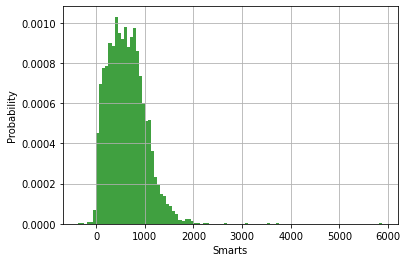

In [194]:
# the histogram of the data
n, bins, patches = plt.hist(feature_df['r_amplitude_mean'], 100, density=True, facecolor='g', alpha=0.75)

plt.xlabel('Smarts')
plt.ylabel('Probability')
plt.grid(True)
plt.show()

In [ ]:
train_feature_filled = feature_df.fillna(feature_df.median())
train_feature_filled.to_csv("gdrive/My Drive/aml_project2/data/X_train_extracted.csv")
test_feature_filled = feature_df_test.fillna(feature_df_test.median())
test_feature_filled.to_csv("gdrive/My Drive/aml_project2/data/X_test_extracted.csv")

# Model Training

In [169]:
from sklearn.ensemble import AdaBoostClassifier,GradientBoostingClassifier,RandomForestClassifier
from sklearn.metrics import f1_score
from sklearn.model_selection import KFold
from sklearn.metrics import plot_confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

In [175]:
y_select = np.array(train_y.drop("id",axis = 1))
x_select = np.array(train_feature_filled)
x_test_select = np.array(test_feature_filled)

/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


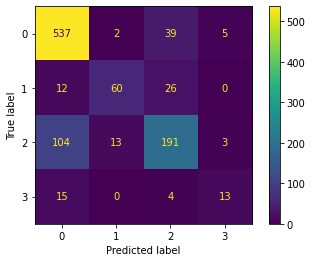

score:  0.7822265625


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


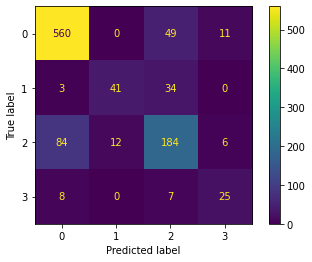

score:  0.791015625


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


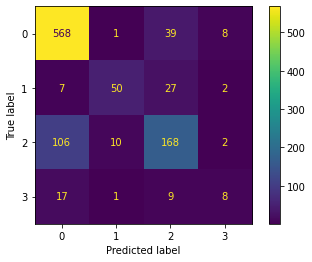

score:  0.7761485826001955


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


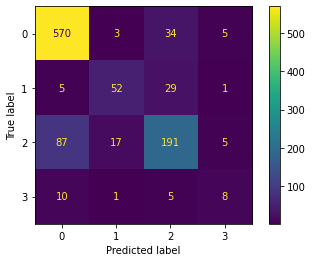

score:  0.8025415444770283


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


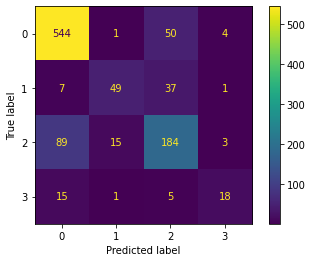

score:  0.7771260997067448


[0.7822265625,
 0.791015625,
 0.7761485826001955,
 0.8025415444770283,
 0.7771260997067448]

In [176]:
scores = []
kf = KFold(n_splits=5, shuffle=True)
clf = GradientBoostingClassifier(n_estimators=300, learning_rate=0.02,max_depth=5, random_state=82)

for train_idx, test_idx in kf.split(x_select):
    x_train = x_select[train_idx]
    y_train = y_select[train_idx]
    x_test = x_select[test_idx]
    y_test = y_select[test_idx]
    clf.fit(x_train,y_train)
    y_pred = clf.predict(x_test)
    s = f1_score(y_test, y_pred, average='micro')
    plot_confusion_matrix(clf,x_test,y_test)
    plt.show()
    print('score: ', s)
    scores.append(s)

scores

In [177]:
print(np.mean(scores))

0.7858116828567938


In [185]:
clf = GradientBoostingClassifier(n_estimators=300, learning_rate=0.02,max_depth=5, random_state=82)
clf.fit(x_select,y_select)
predictions = clf.predict(x_test_select)
predictions

/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


array([0, 2, 0, ..., 0, 0, 1])

In [193]:
pd.DataFrame(list(zip(test_x["id"],predictions)), columns = ["id","y"]).to_csv("gdrive/My Drive/aml_project2/data/samples.csv",index = False)

In [172]:
scores = []
kf = KFold(n_splits=5, shuffle=True)
clf = SVC()

for train_idx, test_idx in kf.split(x_select):
    x_train = x_select[train_idx]
    y_train = y_select[train_idx]
    x_test = x_select[test_idx]
    y_test = y_select[test_idx]
    clf.fit(x_train,y_train)
    y_pred = clf.predict(x_test)
    s = f1_score(y_test, y_pred, average='micro')
    #plot_confusion_matrix(clf,x_test,y_test)
    plt.show()
    print('score: ', s)
    scores.append(s)

print(scores)
print(np.mean(scores))

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


score:  0.7705078125


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


score:  0.7587890625


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


score:  0.7341153470185728


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


score:  0.7585532746823069


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


score:  0.7331378299120236
[0.7705078125, 0.7587890625, 0.7341153470185728, 0.7585532746823069, 0.7331378299120236]
0.7510206653225808
